In [271]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping


In [272]:
df = pd.read_csv(r'D:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\data\processed\telco_data_cleaned.csv') 
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_0–12,tenure_group_13–24,tenure_group_25–36,tenure_group_37–48,tenure_group_49–60,tenure_group_61–72
0,False,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,False,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,False,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,False,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,False,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


In [273]:
# split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

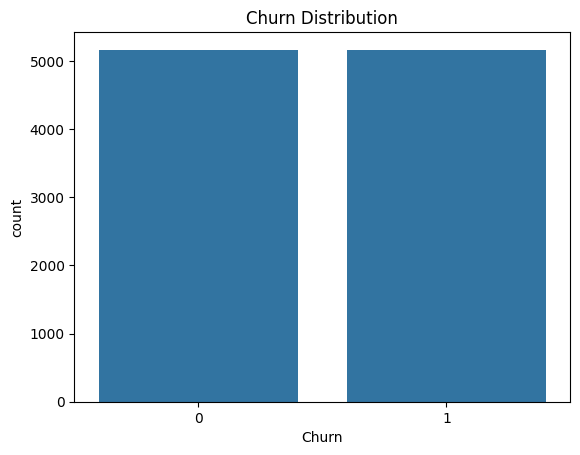

In [274]:
# Visualize the class distribution after resampling
sns.countplot(x=y_resampled)
plt.title('Churn Distribution')
plt.show()

In [275]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [276]:
# SMOTE for balancing classes
sm = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [277]:
# Scale numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns  # Identify numerical columns

scaler = StandardScaler()
X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols]) # Fit and transform on training data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [278]:
# Decision Tree Classifier
#dt_classifier= DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=8, min_samples_split=10, random_state=100)
dt_classifier= DecisionTreeClassifier(random_state=100)
dt_classifier.fit(X_train_resampled, y_train_resampled) # Fit on resampled training data

DecisionTreeClassifier(random_state=100)

In [279]:
# Predictions
y_pred_dt = dt_classifier.predict(X_test)

In [280]:
# Evaluate model
print("Decision Tree Classifier Evaluation:")
dt_classifier.score(X_test, y_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Classifier Evaluation:
Accuracy: 0.738450604122246
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1033
           1       0.51      0.52      0.51       374

    accuracy                           0.74      1407
   macro avg       0.67      0.67      0.67      1407
weighted avg       0.74      0.74      0.74      1407

Confusion Matrix:
 [[844 189]
 [179 195]]


Text(0.5, 1.0, 'Confusion Matrix for  Decision Tree')

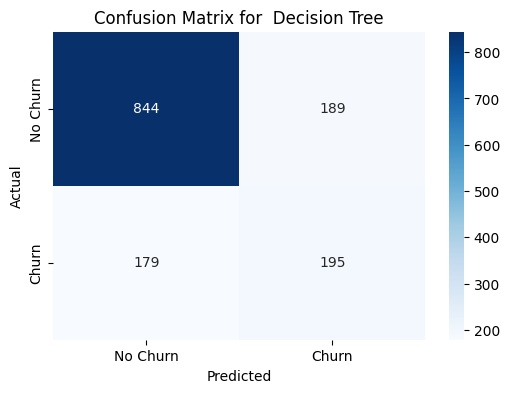

In [281]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for  Decision Tree')

In [282]:
# Hyperparameter tuning with GridSearchCV
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('model', DecisionTreeClassifier())
])

In [283]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'model__max_depth': [3, 5, 7, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

In [284]:
# Perform Grid Search
grid_dt = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='f1',         # Focus on minority class performance
    n_jobs=-1
)

grid_dt.fit(X_train_resampled, y_train_resampled)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 5, 7, None],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [285]:
# Get best  model and make predictions
best_dt = grid_dt.best_estimator_
y_pred = best_dt.predict(X_test)

In [286]:
# Metrics for fine-tuned model
print("Best DT parameters:", grid_dt.best_params_)
print("Best CV F1-score:", grid_dt.best_score_)

Best DT parameters: {'model__criterion': 'gini', 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV F1-score: 0.8126606269567169


In [287]:
# Evaluate fine-tuned model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.7725657427149965
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

Confusion Matrix:
 [[867 166]
 [154 220]]


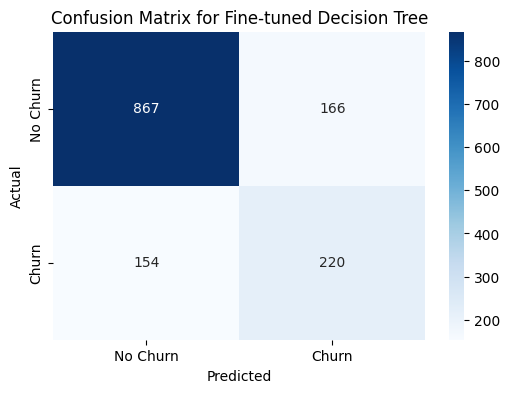

In [288]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix for Fine-tuned Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [289]:
# Compute ROC curve 
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_dt)
# Compute ROC-AUC
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("ROC-AUC:", roc_auc_dt)


ROC-AUC: 0.6692140642228906


## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from kerastuner.tuners import Hyperband



In [300]:
# Define model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])


d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [301]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [302]:
# Train model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train_resampled, y_train_resampled,  # Train on training data only
    validation_split=0.2,  # This now creates validation from training data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7081 - loss: 0.5642 - val_accuracy: 0.8311 - val_loss: 0.5318
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7662 - loss: 0.4887 - val_accuracy: 0.7845 - val_loss: 0.5806
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.4670 - val_accuracy: 0.8160 - val_loss: 0.5057
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.4547 - val_accuracy: 0.8632 - val_loss: 0.3890
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7893 - loss: 0.4465 - val_accuracy: 0.8717 - val_loss: 0.4109
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.4330 - val_accuracy: 0.8880 - val_loss: 0.3621
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.4273 - val_accuracy: 0.8935 - val_loss: 0.3470
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.4227 - val_accuracy: 0.

In [303]:
# Evaluate model on test data
y_pred_proba = model.predict(X_test)
# ---- 2. Convert probabilities to class labels (0 or 1) ----
y_pred = (y_pred_proba > 0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.7945984363894811

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Confusion Matrix:
 [[939  94]
 [195 179]]


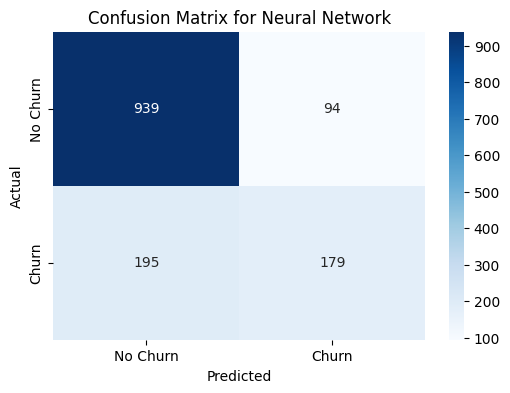

In [314]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Neural Network')
plt.show()

In [304]:
# Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()

    # Number of neurons in first layer
    model.add(Dense(
        units = hp.Int('units_1', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_resampled.shape[1],)
    ))
    
    # Optional dropout
    model.add(Dropout(hp.Float('dropout_1', 0.0, 0.5, step=0.1)))

    # Second hidden layer (tunable units)
    model.add(Dense(
        units = hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.0, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [305]:
# Initialize Keras Tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_results',
    project_name='churn_nn'
)


Reloading Tuner from tuner_results\churn_nn\tuner0.json


In [306]:
# hyperparameter search

tuner.search(
    X_train_resampled, y_train_resampled,  # Training data only!
    epochs=20,
    validation_split=0.2,  # Validation from training data
    callbacks=[EarlyStopping(patience=3)]
)



In [307]:
# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:", best_hp.values)



Best Hyperparameters: {'units_1': 80, 'dropout_1': 0.0, 'units_2': 64, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.002952274106645383, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0008'}


In [308]:
# Get and retrain best model
best_model = tuner.get_best_models(1)[0]


d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [309]:
# Retrain on full training data
history = best_model.fit(
    X_train_resampled, y_train_resampled,  # Training data only!
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8158 - loss: 0.4057 - val_accuracy: 0.9401 - val_loss: 0.1932
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.3758 - val_accuracy: 0.9492 - val_loss: 0.1512
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8343 - loss: 0.3593 - val_accuracy: 0.9631 - val_loss: 0.1006
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8316 - loss: 0.3557 - val_accuracy: 0.9709 - val_loss: 0.0757
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8332 - loss: 0.3538 - val_accuracy: 0.9576 - val_loss: 0.1164
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8373 - loss: 0.3477 - val_accuracy: 0.9891 - val_loss: 0.0509
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8355 - loss: 0.3470 - val_accuracy: 0.9649 - val_loss: 0.0749
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8394 - loss: 0.3347 - val_accuracy: 0.

In [316]:
# Final evaluation on TEST data
y_pred_proba_best = best_model.predict(X_test)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

y_pred_best = (y_pred_proba_best > 0.5).astype(int)

print("\n===== BEST MODEL RESULTS =====")
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

===== BEST MODEL RESULTS =====
Test Accuracy: 0.7469793887704336

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.66      0.58       374

    accuracy                           0.75      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.75      0.76      1407


Confusion Matrix:
 [[803 230]
 [126 248]]


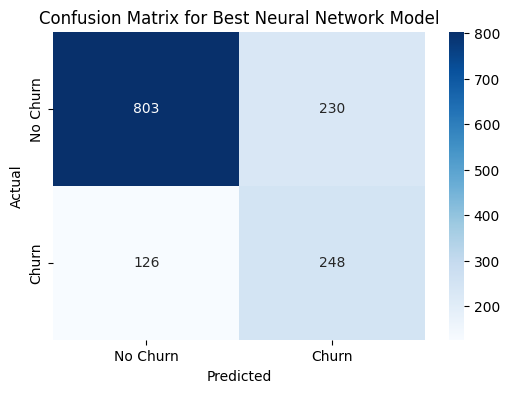

In [317]:
# Visualize Confusion Matrix for best model
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Best Neural Network Model') 
plt.show()

In [312]:
# Compute ROC curve and AUC for best model
y_pred_proba_nn = y_pred_proba_best.ravel()
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
print(f"\nNeural Network ROC-AUC: {roc_auc_nn:.3f}")



Neural Network ROC-AUC: 0.813


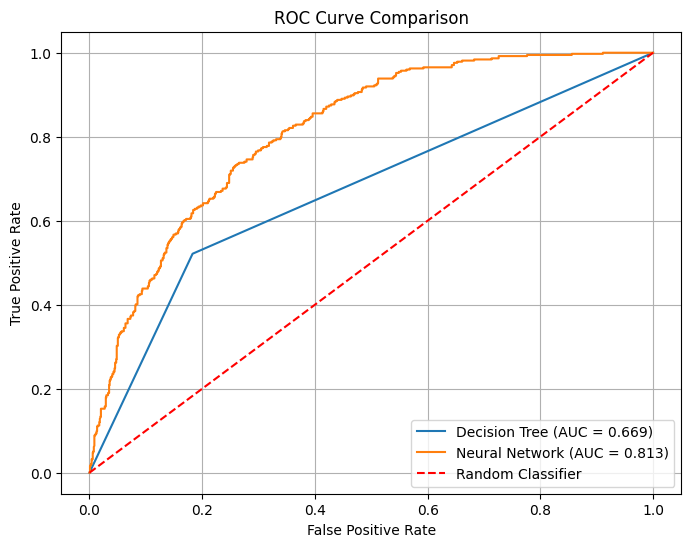

In [313]:
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Classifier')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
